In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import model_from_json


input_encoder = Input(shape=(28, 28, 1))
input_decoder = Input(shape=(4, 4, 4))

with open('decoder.json', 'r') as f:
    decoder = model_from_json(f.read())
    decoder.load_weights("decoder.h5")
    
with open('encoder.json', 'r') as f:
    encoder = model_from_json(f.read())
    encoder.load_weights("encoder.h5")
    
with open('autoencoder.json', 'r') as f:
    autoencoder = model_from_json(f.read())
    autoencoder.load_weights("autoencoder.h5")

/home/ganimedes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

data_x = encoder.predict(x_train)
data_x = data_x.reshape(60000, 64)

In [3]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


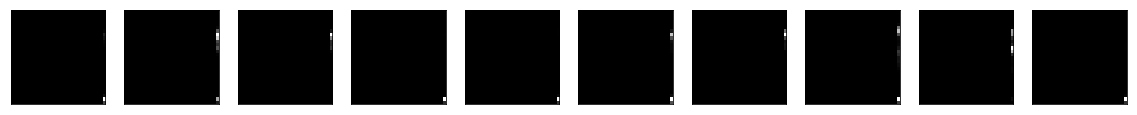

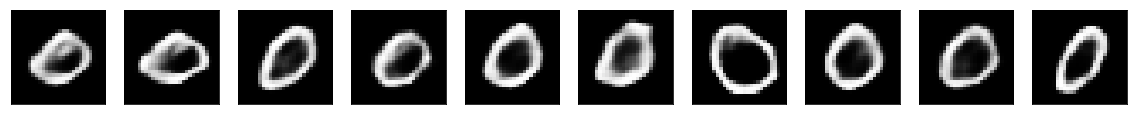

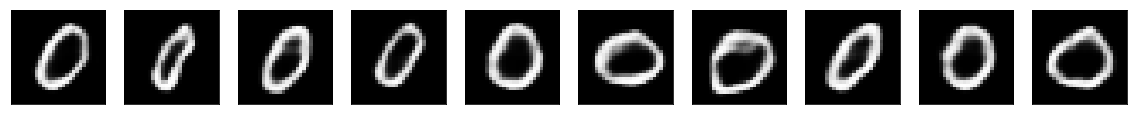

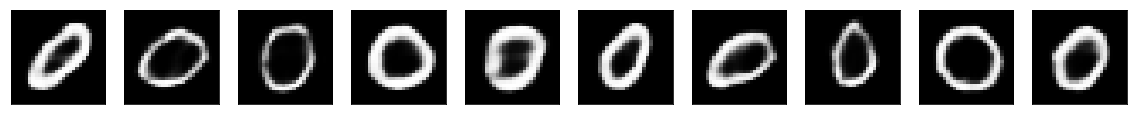

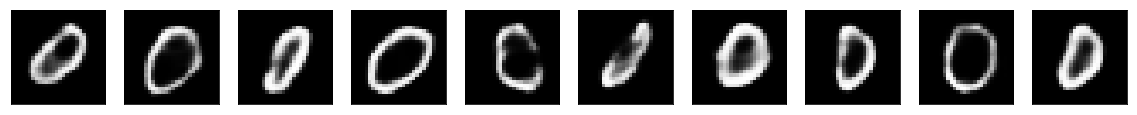

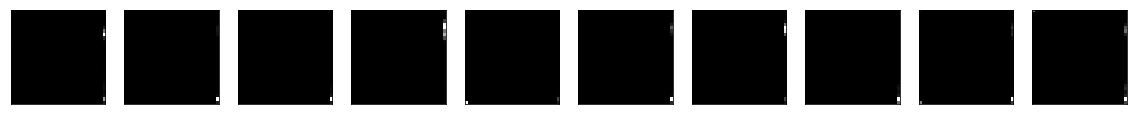

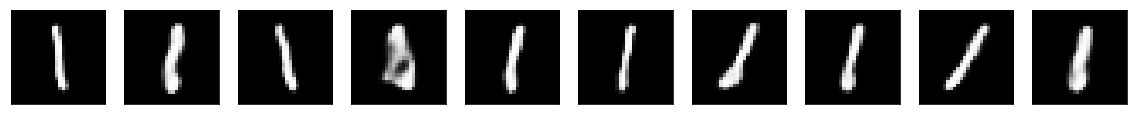

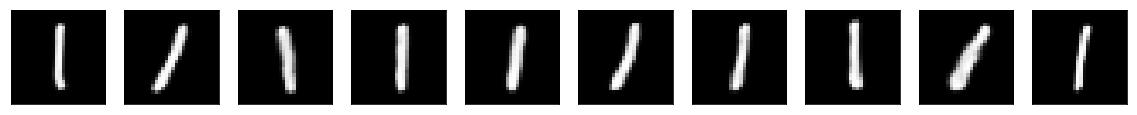

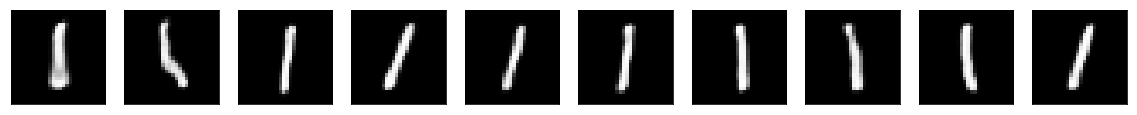

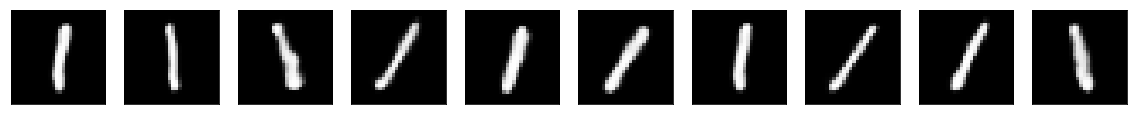

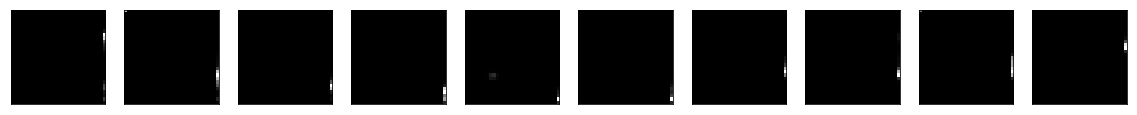

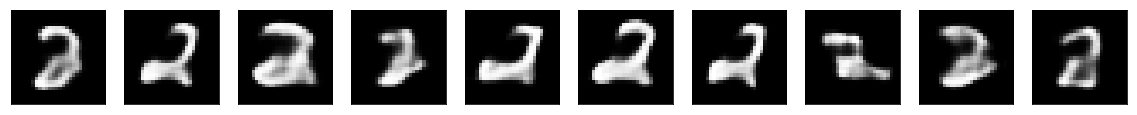

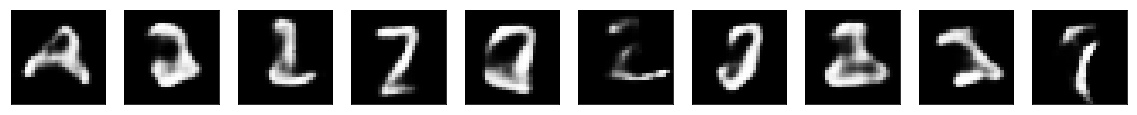

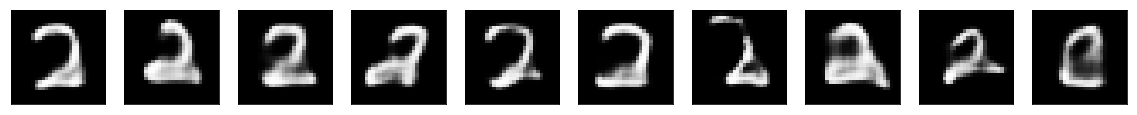

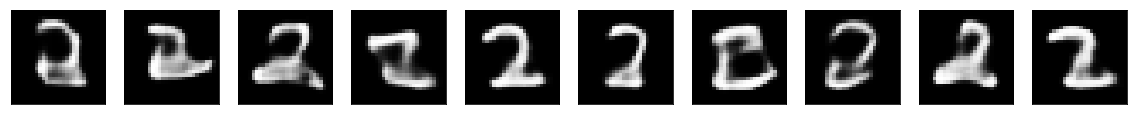

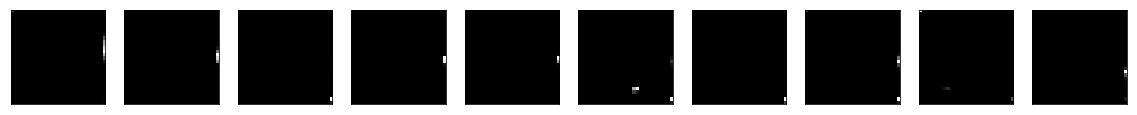

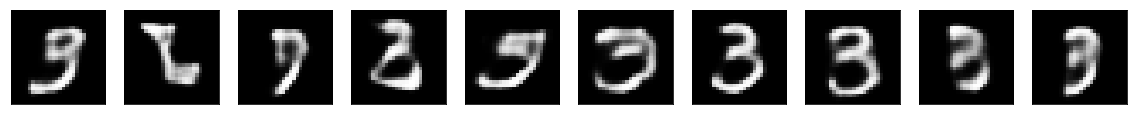

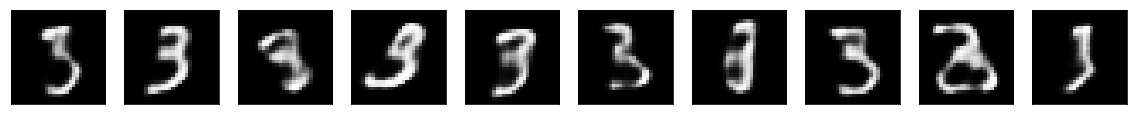

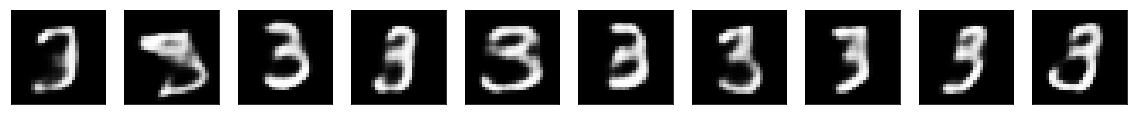

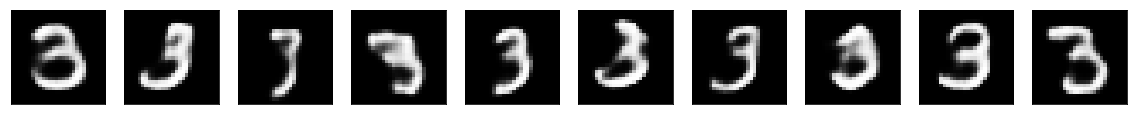

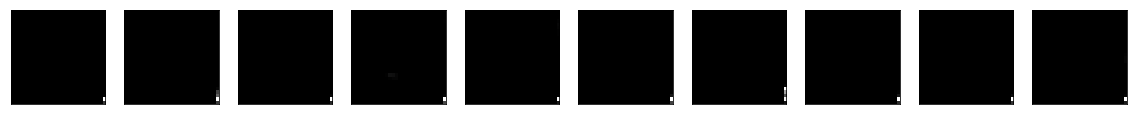

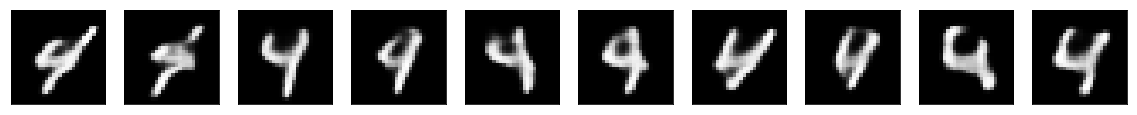

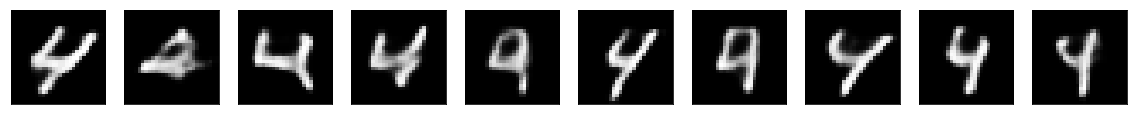

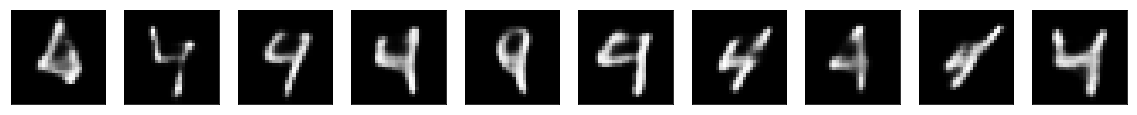

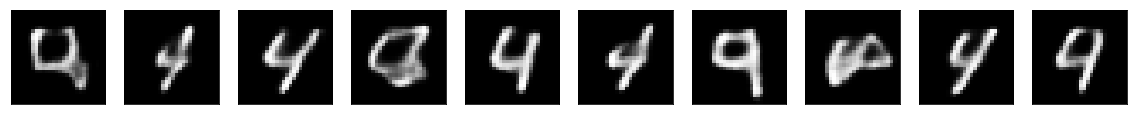

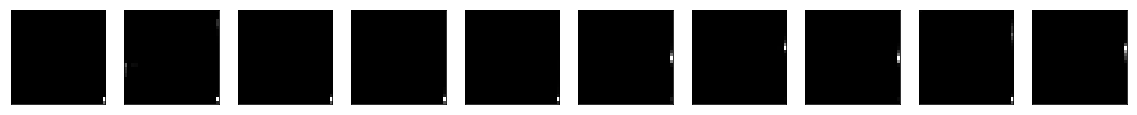

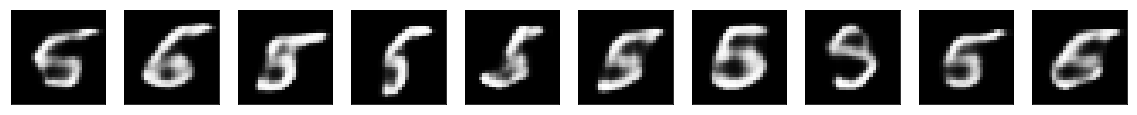

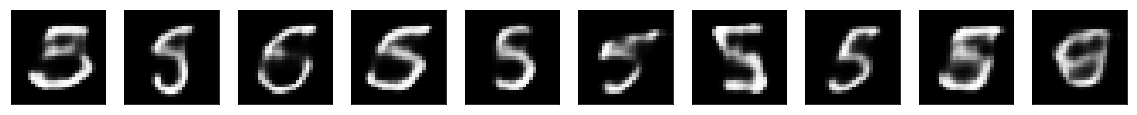

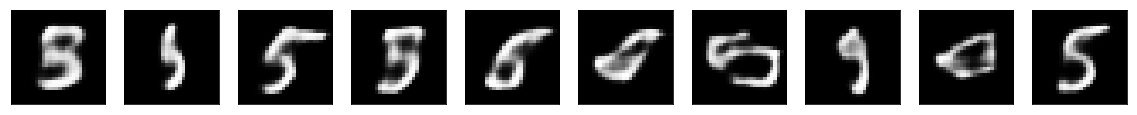

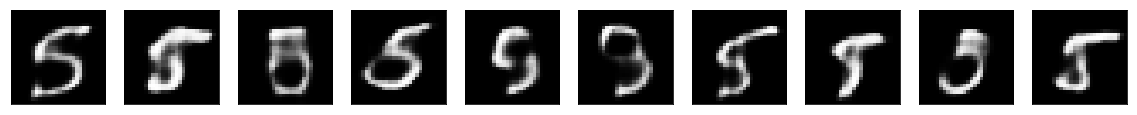

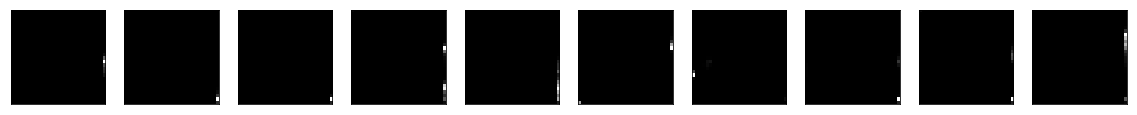

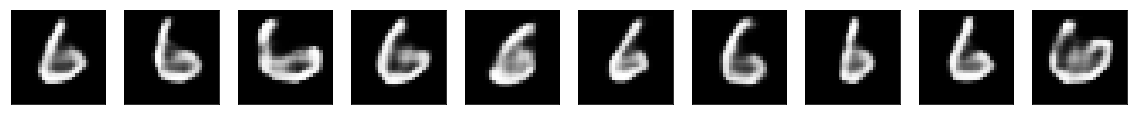

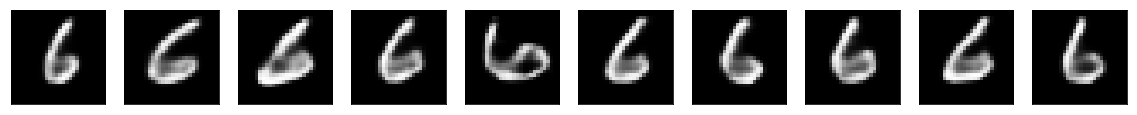

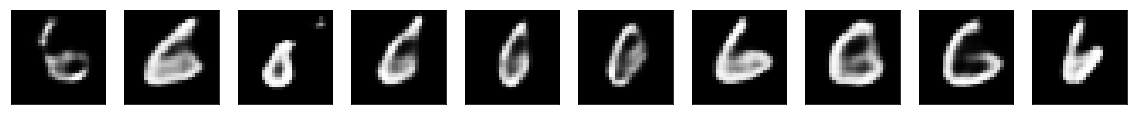

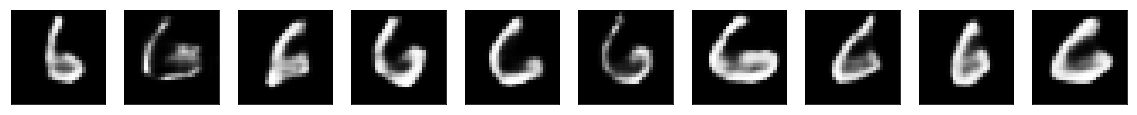

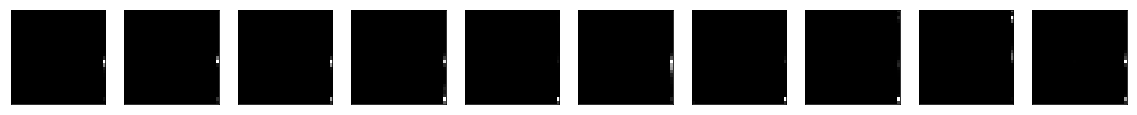

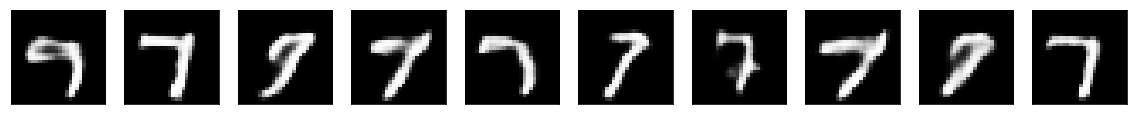

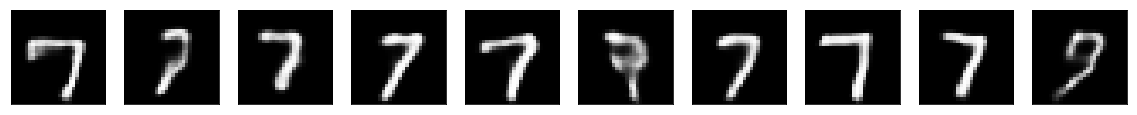

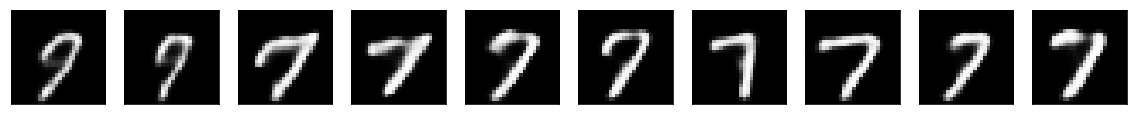

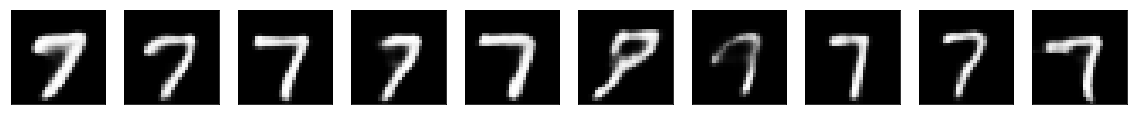

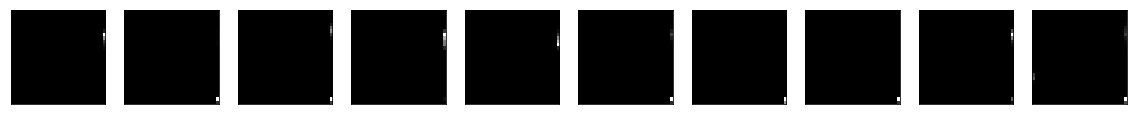

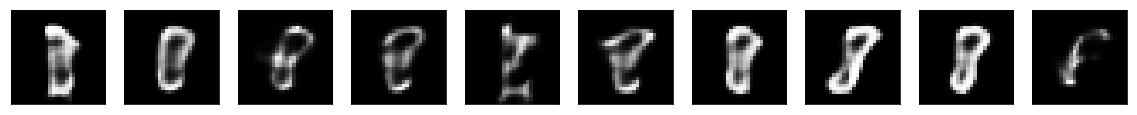

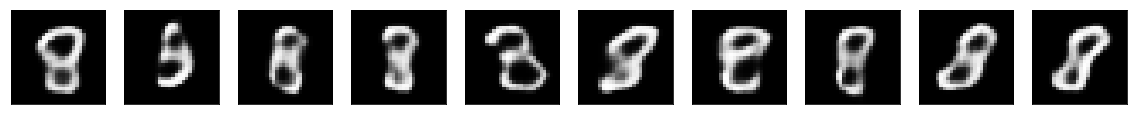

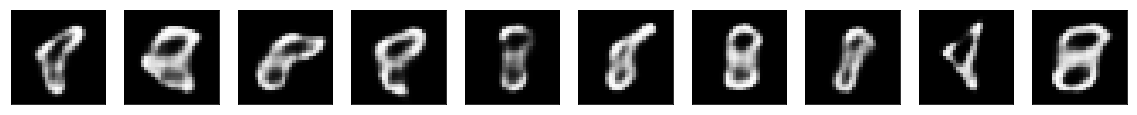

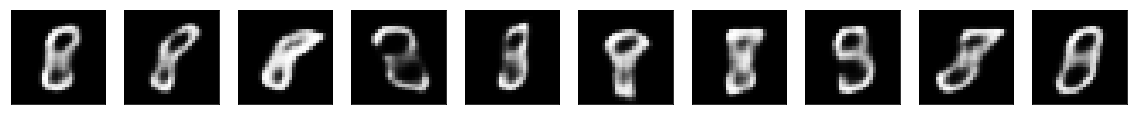

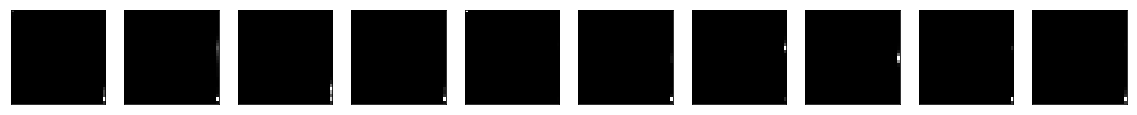

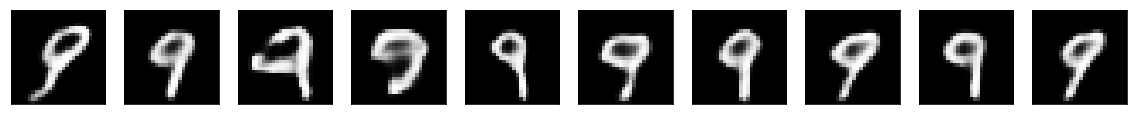

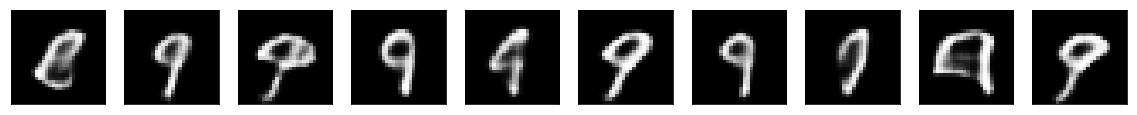

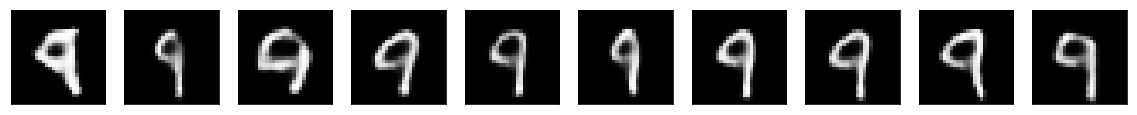

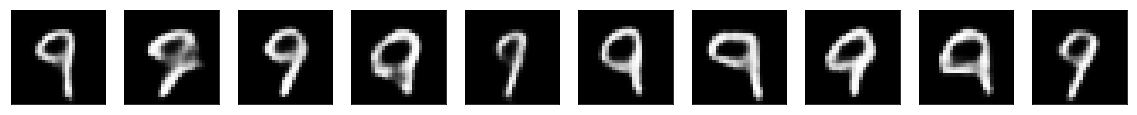

In [4]:
import matplotlib.pyplot as plt

discriminator_input_dim = (64,)
generator_input_dim = (100,)
batch_size = 128
epochs = 5000

discriminator_input = Input(shape=discriminator_input_dim)
generator_input = Input(shape=generator_input_dim)
input_double = Input(shape=generator_input_dim)

def custom_activation(x):
    return (K.sigmoid(x) * 3) 

def discriminator(x):
    hidden1 = Dense(512, activation="relu")(x)
    hidden2 = Dense(512, activation="relu")(hidden1)
    return Dense(1, activation="sigmoid")(hidden2)
    
def generator(x):
    hidden1 = Dense(512, activation="relu")(x)
    hidden2 = Dense(512, activation="relu")(hidden1)
    return Dense(64, activation=custom_activation)(hidden2)


for _class in range(10):
    result = []
    for a, b in zip(data_x, y_train):
        if b == _class:
            result.append(a)
    X_train = np.array(result)
    
    generator_model = Model(generator_input, generator(generator_input))
    discriminator_model = Model(discriminator_input, discriminator(discriminator_input))
    discriminator_model.compile(loss='binary_crossentropy', optimizer="adadelta", metrics=['accuracy'])
    generator_model.compile(loss='binary_crossentropy', optimizer="adadelta")

    img = generator_model(input_double)
    discriminator_model.trainable = False
    valid = discriminator_model(img)

    double_model = Model(input_double, valid)
    double_model.compile(loss='binary_crossentropy', optimizer="adadelta")
    
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):  
        if epoch % 1000 == 0:
            n = 10
            plt.figure(figsize=(20, 4))
            for i in range(n):
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(decoder.predict(generator_model.predict(np.random.normal(0, 1, (1, 100))).reshape((1,4,4,4))).reshape(28, 28))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                plt.gray()
            plt.show()
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator_model.predict(noise)

        d_loss_real = discriminator_model.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator_model.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = double_model.train_on_batch(noise, np.ones((batch_size, 1)))

    
    import json
    with open('models/generator%s.json' % str(_class), 'w') as outfile:
        outfile.write(generator_model.to_json())
    with open('models/discriminator%s.json' % str(_class), 'w') as outfile:
        outfile.write(discriminator_model.to_json())
    
    
    discriminator_model.save_weights('models/discriminator%s.h5' % str(_class))
    generator_model.save_weights('models/generator%s.h5' % str(_class))
